In [260]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown, calculate_conditional_value_at_risk

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 9


## Problem 1:  Portfolio characteristics 

In this exercise, we will compare a value weighted versus an equally weighted strategy on the sector level. 

__Question 1__

Obtain the Fama-French "12 industry portfolios" since 1999. Calculate a equally weighted return index and a value weighted return index. 

Plot the time series of the index development. 

__Question 2__

Plot a drawdown plot for the two indices. 

__Question 3__

Calculate the arihmetic and geometric return. 

__Question 4__

Calculate the ann. volatility. Also calculate the skewness and kurtosis. 

__Question 5__

Which strategy would you prefer?


### Solution 

__Question 1__

In [12]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202308 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (296 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (296 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (24 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (24 rows x 12 cols)\n  4 : Number of Firms in Portfolios (296 rows x 12 cols)\n  5 : Average Firm Size (296 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (25 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (25 rows x 12 cols)'

In [13]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [14]:
mkt_index = (1 + market_return).cumprod()
eq_index = (1 + equal_weighted_return).cumprod()

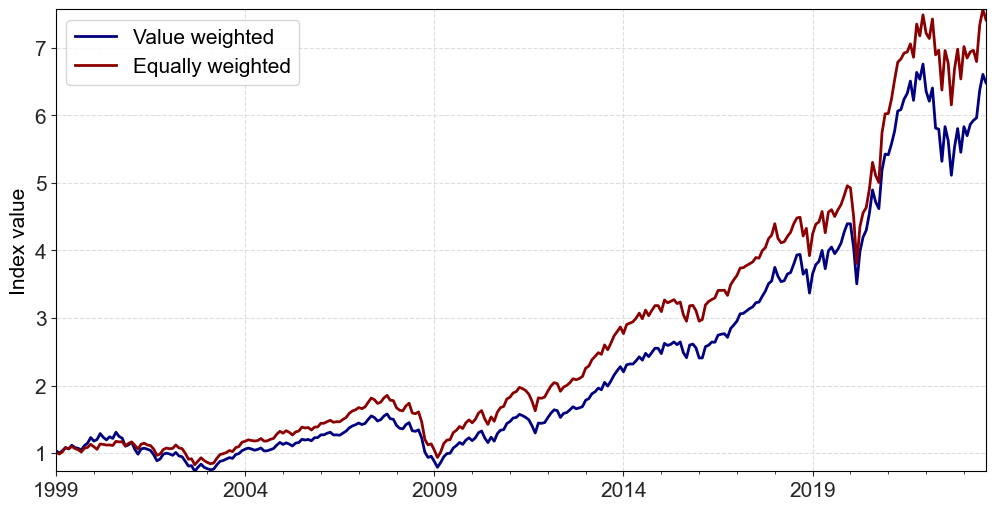

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

mkt_index.plot(color="navy", label="Value weighted", xlabel="")
eq_index.plot(color="darkred", label="Equally weighted", xlabel="")
ax.set_ylabel("Index value")
ax.legend();

__Question 2__



In [16]:
dd_mkt = drawdown(mkt_index)[0]
dd_eq = drawdown(eq_index)[0]

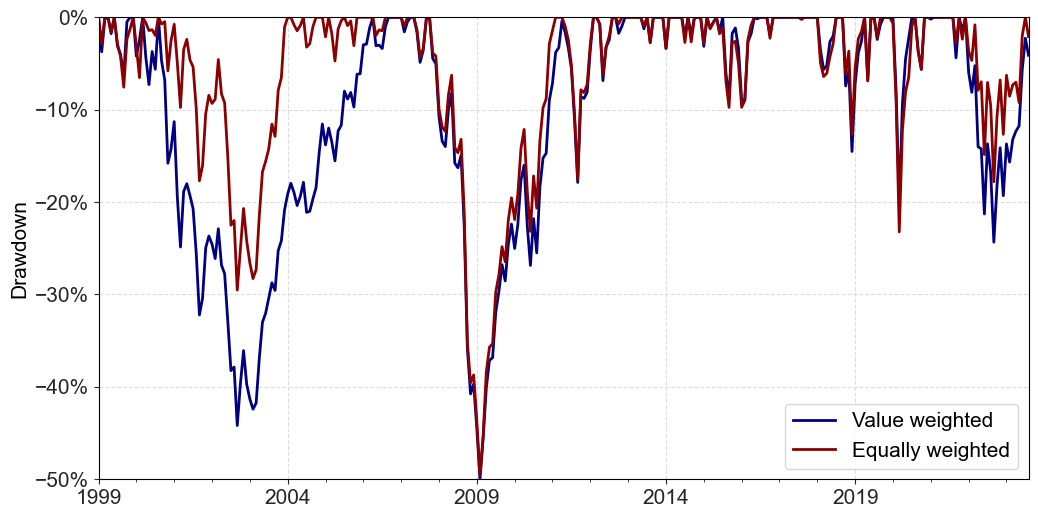

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

dd_mkt.plot(color="navy", label="Value weighted", xlabel="")
dd_eq.plot(color="darkred", label="Equally weighted", xlabel="")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylabel("Drawdown")
ax.legend();

__Question 3 and 4__

In [18]:
portfolio_descriptive = pd.DataFrame(columns=['Value weighted', 'Equally weighted'])

portfolio_descriptive.loc['Arithmetic Avg. return (ann.)', 'Value weighted'] = np.average(market_return) * 12
portfolio_descriptive.loc['Arithmetic Avg. return (ann.)', 'Equally weighted'] = np.average(equal_weighted_return) * 12

portfolio_descriptive.loc['Geometric return (ann.)', 'Value weighted'] = mkt_index.values[-1]**(12 / len(mkt_index)) - 1
portfolio_descriptive.loc['Geometric return (ann.)', 'Equally weighted'] = eq_index.values[-1]**(12 / len(eq_index)) - 1

portfolio_descriptive.loc['Volatility (ann.)', 'Value weighted'] = market_return.std() * np.sqrt(12)
portfolio_descriptive.loc['Volatility (ann.)', 'Equally weighted'] = equal_weighted_return.std() * np.sqrt(12)

portfolio_descriptive.loc['Kurtosis', 'Value weighted'] = market_return.kurt()
portfolio_descriptive.loc['Kurtosis', 'Equally weighted'] = equal_weighted_return.kurt()

portfolio_descriptive.loc['Skewness', 'Value weighted'] = market_return.skew()
portfolio_descriptive.loc['Skewness', 'Equally weighted'] = equal_weighted_return.skew()


In [19]:
portfolio_descriptive

,Value weighted,Equally weighted
Arithmetic Avg. return (ann.),0.088441,0.093202
Geometric return (ann.),0.078713,0.084602
Volatility (ann.),0.157123,0.152654
Kurtosis,0.778299,1.670494
Skewness,-0.489341,-0.427003


__Quesition 5__

?

## Problem 2: Satisfaction and portfolio optimization 

For simplicity, we consider the case where the linear returns follow a multivariate normal distribution 

$$
\mathbf{R} \sim MVN(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Furthermore, assume that the investor's utility is given as a function of the wealth one year in the future $\Psi_1$ (exponential utility)

$$
U(\Psi_1) = -e^{-\frac{1}{\gamma} \Psi_1}, \; \gamma>0,
$$

the initial wealth is $\psi_0 = 1$, and that all assets has an initial price of one. 

__Question 1__

Derive the distribution of wealth $\Psi_1$ when assuming the allocation $\boldsymbol{\alpha}$ such that the wealth after one year is given by 

$$
\Psi_1 = \boldsymbol{\alpha}^\top (1  + \mathbf{R})
$$

__Question 2__

Since the wealth $\Psi_1$ will be normally distributed, then it is possible to show that 

$$
E[-e^{-\frac{1}{\gamma} \Psi_1}] = -e^{-\frac{1}{\gamma} E[\Psi_1] + \frac{1}{2 \gamma^2}Var[\Psi_1]}
$$

The Certainty-Equivalent (CE) is given by (should look familiar)

$$
\text{CE}(\boldsymbol{\alpha}) = U^{-1}(E[-e^{-\frac{1}{\gamma} \Psi_1}]) = - \gamma \ln (-E[-e^{-\frac{1}{\gamma} \Psi_1}]) =  E[\Psi_1] - \frac{1}{2 \gamma}Var[\Psi_1]
$$

Assume $\gamma = 5$. Plot level curves, the combinations of $E[\Psi_1]$ and $Var[\Psi_1]$ that give the same utility, when the asset universe consists of 10 assets with $\boldsymbol{\mu} = (0.01, 0.02, ...,  0.10)^\top$ and $\boldsymbol{\Sigma} = Diag((0.05^2, 0.06^2, ..., 0.14^2))$. At least plot the level curve on which the equally weighted portfolio is (note that the equally weighted portfolio is defined by $\alpha_i = \psi_0 / 10$ for $i=1, ..., 10$).

__Question 3__

Find the optimal allocation

$$
\boldsymbol{\alpha}^* = \arg \max_{\boldsymbol{\alpha}} \boldsymbol{\alpha} (1 + \boldsymbol{\mu}) - \frac{1}{2 \gamma} \boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}
$$

subject to $\boldsymbol{\alpha}^\top \boldsymbol{1} = \psi_0$. 

Define a function calculating the optimal allocation and calculate thereafter the optimal allocation. 

Add the level curve on which we find the optimal portfolio to the plot. 

__Question 4__

Add the mean-variance efficient frontier to the plot. What to you observe?


### Solution 

__Question 1__

$$
\Psi_1 \sim N(\boldsymbol{\alpha}^\top (1  + \boldsymbol{\mu}), \boldsymbol{\alpha}^\top \Sigma \boldsymbol{\alpha})
$$

__Question 2__

In [226]:
num_assets = 10
mu = np.arange(0.01, 0.101, 0.01)
vols = np.arange(0.05, 0.141, 0.01)
cov_mat = np.diag(vols)
gamma = 1
initial_wealth = 1 # _000_000

In [227]:
def calculate_port_variance(alpha: np.ndarray, cov_mat: np.ndarray): 
    
    return alpha @ cov_mat @ alpha 

def calculate_port_expected_value(alpha: np.ndarray, mu: np.ndarray): 
    
    return alpha @ (1 + mu)

def calculate_certainty_equivalent(alpha: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, gamma: float = 5.0): 
    
    exp_wealth = calculate_port_expected_value(alpha, mu)
    var_wealth = calculate_port_variance(alpha, cov_mat)
    
    return exp_wealth - 0.5 / gamma * var_wealth

In [228]:
w_eq = np.ones(num_assets) / num_assets
alpha_eq = w_eq * initial_wealth
eq_expected_wealth = calculate_port_expected_value(alpha_eq, mu)
eq_var = calculate_port_variance(alpha_eq, cov_mat)
eq_ce = calculate_certainty_equivalent(alpha_eq, mu, cov_mat, gamma=gamma)

In [229]:
eq_ce

1.0502500000000001

Solving for $E[\Psi_1]$ in $\text{CE}(\boldsymbol{\alpha}) = E[\Psi_1] - \frac{1}{2 \gamma}Var[\Psi_1]$ yields

$$
E[\Psi_1] = \text{CE}(\boldsymbol{\alpha}) +  \frac{1}{2 \gamma}Var[\Psi_1]
$$

which we can use to plot level curves

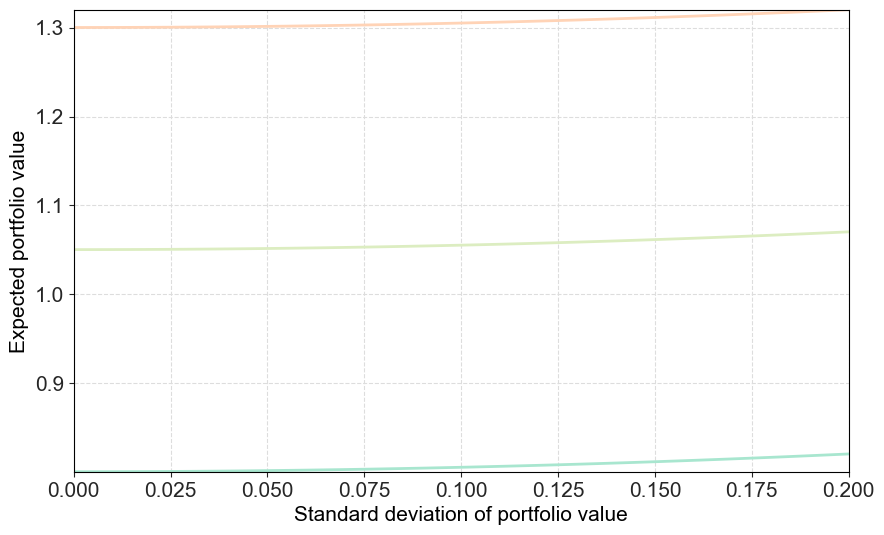

In [230]:
ce_levels = [-0.25 + eq_ce, eq_ce, eq_ce + 0.25]
std_values = np.linspace(0, 0.2, 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(std_values, ce_levels[0] + 0.5 / gamma * std_values**2)
ax.plot(std_values, ce_levels[1] + 0.5 / gamma * std_values**2)
ax.plot(std_values, ce_levels[2] + 0.5 / gamma * std_values**2)

ax.set(xlabel="Standard deviation of portfolio value", ylabel="Expected portfolio value");

__Question 3__

From the problem

$$
\boldsymbol{\alpha}^* = \arg \max_{\boldsymbol{\alpha}} \boldsymbol{\alpha} (1 + \boldsymbol{\mu}) - \frac{1}{2 \gamma} \boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}
$$

subject to $\boldsymbol{\alpha}^\top \boldsymbol{1} = \psi_0$, we can write the Lagrangian ($\lambda$ is here the Lagrange multiplier)

$$
\mathcal{L}(\boldsymbol{\alpha}, \lambda) = \boldsymbol{\alpha} (1 + \boldsymbol{\mu}) - \frac{1}{2 \gamma} \boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha} + \lambda \left(\boldsymbol{\alpha}^\top \mathbf{1} - \psi_0 \right)
$$


The first order conditions read

$$
\begin{align}
\frac{\partial \mathcal{L}(\boldsymbol{\alpha}, \lambda)}{\partial \boldsymbol{\alpha}} &=  (1 + \boldsymbol{\mu}) - \frac{1}{\gamma} \boldsymbol{\Sigma} \boldsymbol{\alpha}  + \lambda \mathbf{1} = \mathbf{0} \\
\frac{\partial \mathcal{L}(\boldsymbol{\alpha}, \lambda)}{\partial \lambda} &= \boldsymbol{\alpha}^\top \mathbf{1} - \psi_0 = 0
\end{align}
$$

From the first condition, we obtain 

$$
\boldsymbol{\alpha}^* =  \gamma \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \gamma \boldsymbol{\Sigma}^{-1} \lambda \mathbf{1}
$$

Then, we obtain 

$$
\mathbf{1}^\top \boldsymbol{\alpha}^* = \gamma  \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \gamma \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}  \mathbf{1} \lambda = \psi_0
$$

Thus, 

$$
\lambda^* = \frac{\psi_0 -  \gamma  \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})}{\gamma \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}  \mathbf{1}}
$$

Inserting into the optimality condition for $\boldsymbol{\alpha}$

$$
\boldsymbol{\alpha}^* =  \gamma \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \gamma \boldsymbol{\Sigma}^{-1} \lambda \mathbf{1} = \gamma \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \frac{\psi_0 -  \gamma  \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})}{ \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}  \mathbf{1}} \boldsymbol{\Sigma}^{-1}  \mathbf{1}
$$

In [231]:
def calculate_optimal_alpha(mu: np.ndarray, cov_mat: np.ndarray, initial_wealth, gamma: float = 5.0): 
    
    cov_mat_inv = np.linalg.inv(cov_mat)
    one_vec = np.ones_like(mu)
    
    part1 = gamma*cov_mat_inv @ (1 + mu)
    
    part2 = (initial_wealth - one_vec @ part1)  * cov_mat_inv @ one_vec  / (one_vec @ cov_mat_inv @ one_vec)
    
    return part1 + part2

In [253]:
alpha_opt = calculate_optimal_alpha(mu, cov_mat, initial_wealth, gamma)
opt_expected_wealth = calculate_port_expected_value(alpha_opt, mu)
opt_var = calculate_port_variance(alpha_opt, cov_mat)
opt_ce = calculate_certainty_equivalent(alpha_opt, mu, cov_mat, gamma=gamma)

In [254]:
alpha_opt

array([-0.54079381, -0.28399484, -0.10056701,  0.03700387,  0.14400344,
        0.2296031 ,  0.29963918,  0.35800258,  0.407387  ,  0.4497165 ])

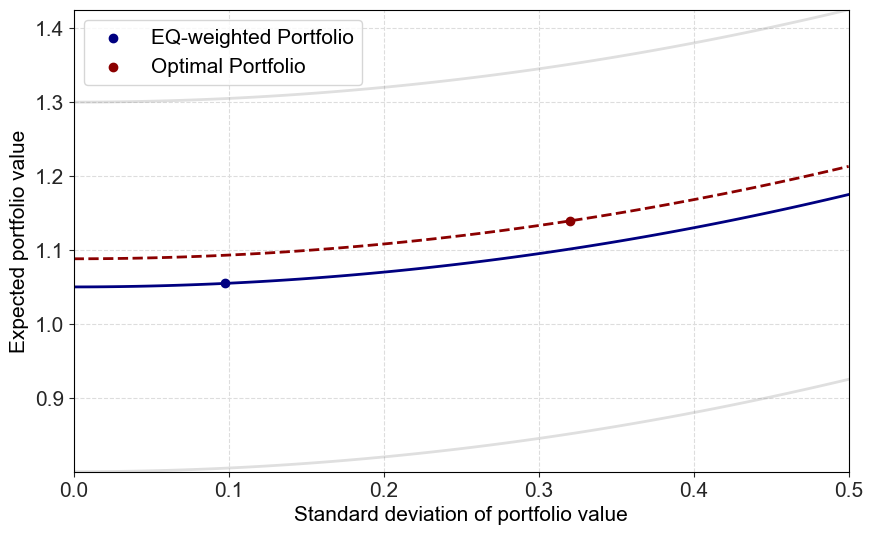

In [255]:
ce_levels = [-0.25 + eq_ce, eq_ce, eq_ce + 0.25]
std_values = np.linspace(0, 0.5, 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(std_values, ce_levels[0] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(eq_var), eq_expected_wealth, color="navy", label="EQ-weighted Portfolio")
ax.plot(std_values, ce_levels[1] + 0.5 / gamma * std_values**2, color="navy")

ax.plot(std_values, ce_levels[2] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(opt_var), opt_expected_wealth, color="darkred", label="Optimal Portfolio")
ax.plot(std_values, opt_ce + 0.5 / gamma * std_values**2, color="darkred", linestyle="--")

ax.set(xlabel="Standard deviation of portfolio value", ylabel="Expected portfolio value");

ax.legend();

__Question 4__

Apply the a the formula for mean-variance optimal portfolio from the lectures. 

In [256]:
def calculate_mvo_portfolio(mu: np.ndarray, cov_mat: np.ndarray, target: float, initial_wealth):
    
    b = np.r_[np.zeros_like(mu), target, initial_wealth]
    A = np.vstack((np.c_[2*cov_mat, (1 + mu), np.ones_like(mu)], 
                  np.r_[(1 + mu), 0, 0], np.r_[np.ones_like(mu), 0, 0]))
    
    alpha_opt = np.linalg.inv(A) @ b
    
    return alpha_opt[:len(mu)]

In [257]:
targets = np.linspace(initial_wealth, initial_wealth*(1 + 0.2), 50)

mean_var_eff_alpha = np.array([calculate_mvo_portfolio(mu, cov_mat, t, initial_wealth)  for  t in targets])

In [258]:
std_eff = np.sqrt(np.apply_along_axis(calculate_port_variance, 1, mean_var_eff_alpha, (cov_mat)))
expectation_eff = np.apply_along_axis(calculate_port_expected_value, 1, mean_var_eff_alpha, (mu))

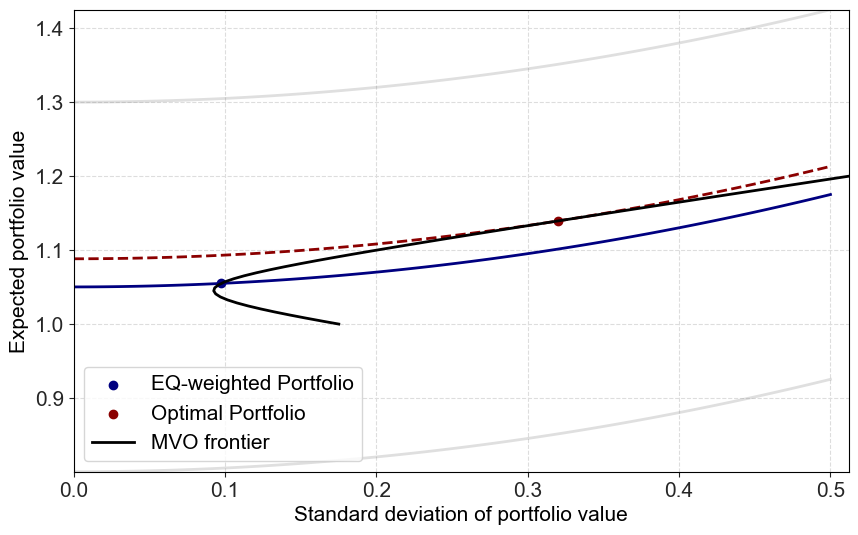

In [259]:
ce_levels = [-0.25 + eq_ce, eq_ce, eq_ce + 0.25]
std_values = np.linspace(0, 0.5, 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(std_values, ce_levels[0] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(eq_var), eq_expected_wealth, color="navy", label="EQ-weighted Portfolio")
ax.plot(std_values, ce_levels[1] + 0.5 / gamma * std_values**2, color="navy")

ax.plot(std_values, ce_levels[2] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(opt_var), opt_expected_wealth, color="darkred", label="Optimal Portfolio")
ax.plot(std_values, opt_ce + 0.5 / gamma * std_values**2, color="darkred", linestyle="--")

ax.plot(std_eff, expectation_eff, color="black", label="MVO frontier")

ax.set(xlabel="Standard deviation of portfolio value", ylabel="Expected portfolio value");

#ax.set_ylim([0.75, 1.25])
ax.legend();

## Problem 3:  Long-term risk and portfolio optimization 

Again, consider the Fama-French "12 industry portfolios" since 1999.

__Question 1__

We may assume that log-returns follows a multivariate normal distribution. 

$$
\log \mathbf{P}_{t+1} - \log \mathbf{P}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Estimate the expected log-return and the covariance matrix of log-returns. 

__Question 2__

Based on the above estimates, simulate the asset prices 5-years into the future. Consider 10,000 paths and yearly time steps. 

Calculate the return of an equally weighted constant mix portfolio. Plot a fan chart of the development of the index value of the constant mix. Compare with a buy and hold portfolio. 

__Question 3__

Calculate the mean, variance and CVaR at the 5-year horizon. 

__Question 4__

Select the constant mix portfolio that minimizes the 5Y CVaR(5%) for a return target of e.g. $50\%$.  

__Question 5__

Suggest and apply a resampling approach. 

__Question 6__

Do we obtain similar results with a buy and hold strategy?

### Solution 

__Question 1__

As previously seen, we can simply use `pandas-datareader`. 

In [261]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202308 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (296 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (296 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (24 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (24 rows x 12 cols)\n  4 : Number of Firms in Portfolios (296 rows x 12 cols)\n  5 : Average Firm Size (296 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (25 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (25 rows x 12 cols)'

In [262]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()


# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()

asset_list = ind_mc_weighted.columns

In [263]:
"""
Calculate log returns
"""

log_returns = np.log(1+ind_mc_weighted)

In [264]:
mean_log_returns = log_returns.mean()
mean_log_returns

NoDur    0.006531
Durbl    0.006123
Manuf    0.007947
Enrgy    0.007206
Chems    0.006340
BusEq    0.007132
Telcm    0.002089
Utils    0.006227
Shops    0.007403
Hlth     0.006369
Money    0.004949
Other    0.004861
dtype: float64

In [265]:
cov_mat_log_returns = log_returns.cov()
cov_mat_log_returns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
NoDur,0.001375,0.001635,0.001501,0.001406,0.001257,0.001101,0.001224,0.000988,0.001116,0.000949,0.001506,0.001324
Durbl,0.001635,0.007938,0.003910,0.002871,0.002329,0.003909,0.002656,0.001285,0.002980,0.001636,0.003555,0.003527
Manuf,0.001501,0.003910,0.003462,0.002827,0.002090,0.002977,0.002221,0.001263,0.002112,0.001418,0.002785,0.002822
Enrgy,0.001406,0.002871,0.002827,0.005239,0.001785,0.001904,0.001871,0.001578,0.001450,0.001155,0.002455,0.002277
Chems,0.001257,0.002329,0.002090,0.001785,0.001877,0.001573,0.001394,0.001023,0.001368,0.001110,0.001852,0.001795
BusEq,0.001101,0.003909,0.002977,0.001904,0.001573,0.005014,0.002605,0.000773,0.002288,0.001424,0.002281,0.002766
Telcm,0.001224,0.002656,0.002221,0.001871,0.001394,0.002605,0.002898,0.000903,0.001700,0.001197,0.002055,0.002077
Utils,0.000988,0.001285,0.001263,0.001578,0.001023,0.000773,0.000903,0.001885,0.000772,0.000795,0.001114,0.001093
Shops,0.001116,0.002980,0.002112,0.001450,0.001368,0.002288,0.001700,0.000772,0.002145,0.001087,0.001961,0.001961
Hlth,0.000949,0.001636,0.001418,0.001155,0.001110,0.001424,0.001197,0.000795,0.001087,0.001714,0.001448,0.001343


In [266]:
corr_mat_log_returns = cov_to_corr_matrix(cov_mat_log_returns)

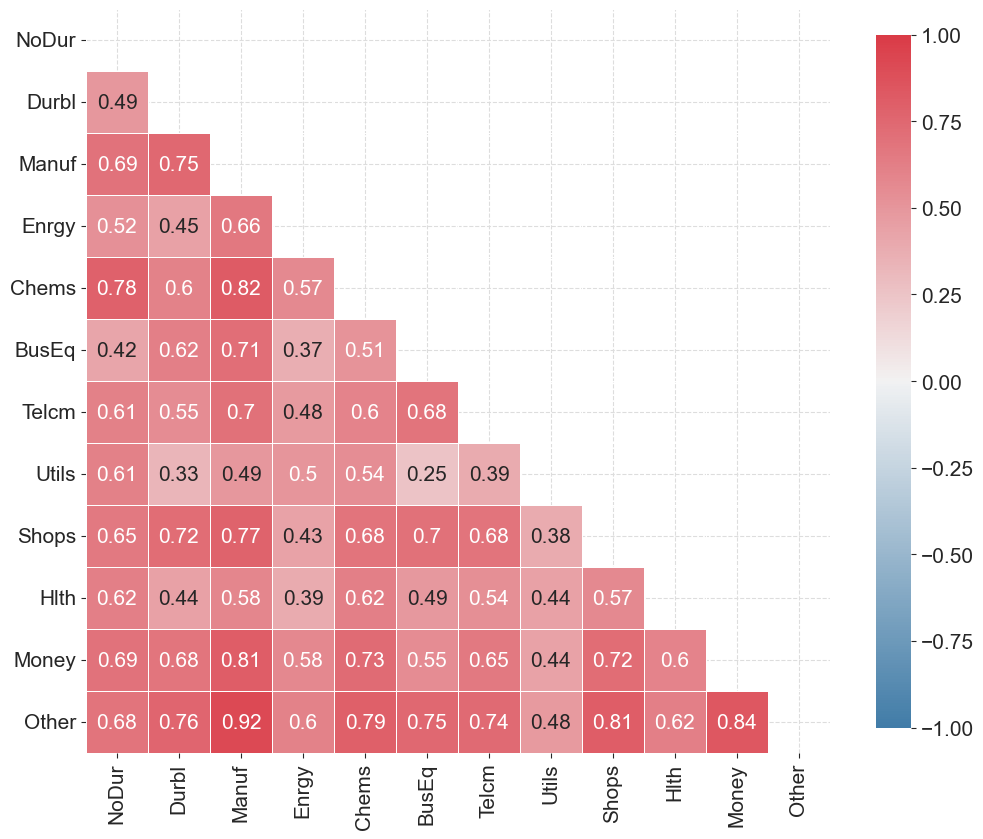

In [267]:
fig, ax = plt.subplots(figsize=(12, 12))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

__Question 2__

We can simulate log-returns using a multivariate normal distribution and aggregate across time. 

In [268]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [269]:
"""
Simulate asset prices
"""

num_sim = 5000
dt = 1.0 # 1.0/12.0
horizon = 5.0
mu = mean_log_returns.values * 12.0
cov_mat = cov_mat_log_returns * 12.0

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

The value of a buy and hold strategy is simply given by (assuming the initial value of the assets and portfolios are equal to 1)

$$
V_T = \mathbf{w}^\top \mathbf{P}_T
$$

where $V_T$ denotes the portfolio value, $\mathbf{P}_T$ denotes the vector of asset prices and $\mathbf{w}$ denote the initial portfolio weights. 

In [270]:
"""
Buy and hold strategy 
"""

port_w = np.ones(len(mu)) / len(mu)

buy_and_hold_index = asset_prices @ port_w

In [271]:
asset_prices.shape

(5000, 6, 12)

In [272]:
buy_and_hold_index.shape

(5000, 6)

The value of the constant mix strategy 

$$
V_T = \prod_{t = 1}^T (1 + \mathbf{w}^\top \mathbf{R}_t)
$$

where $\mathbf{R}_t$ is the period return of the assets. 

In [273]:
"""
Constant mix porfolio (monthly rebalancing)
"""

def calculate_period_returns(index: np.ndarray) -> np.ndarray:
    
    """
    Calculates period returns
    
    Paramters
    ---------
    index: 
        Index values [num sim x num time steps x num_assets]. 
        
    Returns
    -------
    np.ndarray
        Period returns. 
    
    """
    
    # get size of matrix
    n = index.shape[1]

    # get matrix not lagged
    new_mat = index[:, 1:n]
    # get matrix lagged
    old_mat = index[:, 0:n-1]
    # get 1 + return
    periodtr = new_mat / old_mat
    
    return periodtr - 1
    

def calculate_constant_mix_index(index: np.ndarray, weights: np.ndarray) -> np.ndarray:
    
    """
    Calculates cum. return index of a constant mix strategy. 
    
    Parameters
    ----------
    index: 
        Index values  [num sim x num time steps x num_assets]. 
    weights: 
        Portfolio weights. 
        
    
    Returns
    -------
    np.ndarray
        Cum. return index [num sim x num time steps]. 
    
    """
    
    port_index = np.ones((index.shape[0], index.shape[1]))
    
    # calculate period returns on assets
    per_ret = calculate_period_returns(index)
    
    # calculate port. period return
    port_per_ret = per_ret @ weights
    
    # calculate port. index
    port_index[:, 1:] = np.cumprod(1 + port_per_ret, axis=1)
    
    return port_index
    

constant_mix_index = calculate_constant_mix_index(asset_prices, port_w)

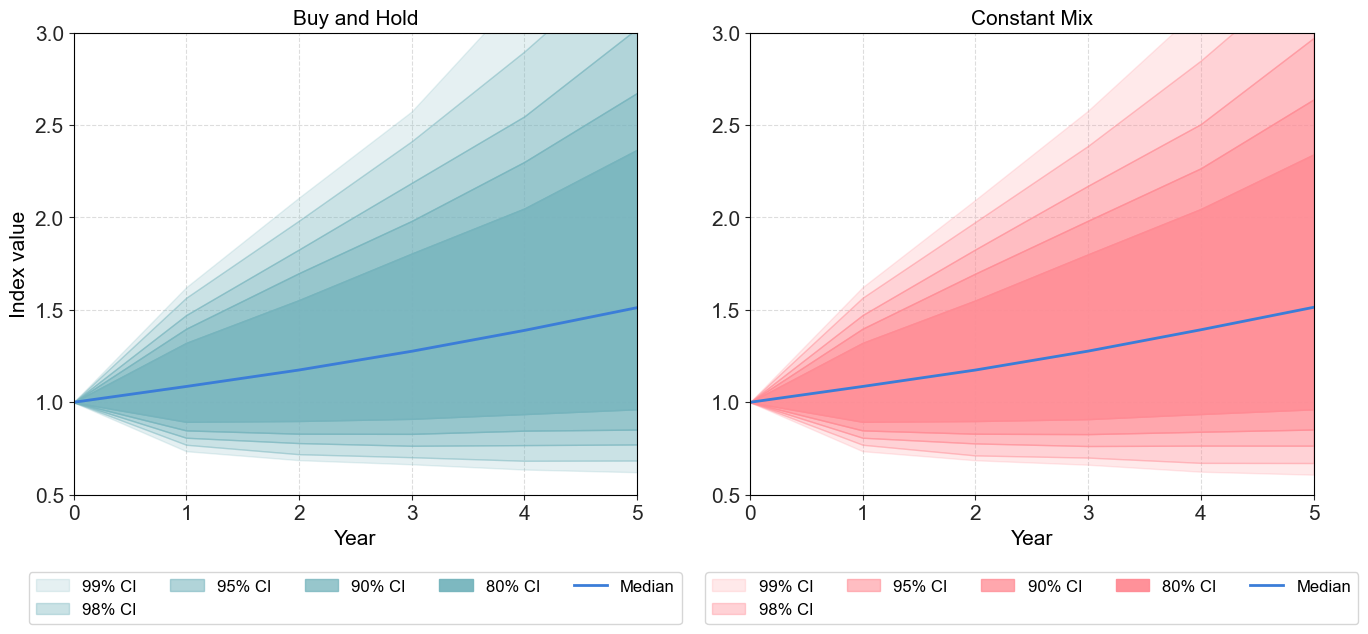

In [274]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
percentiles_constant_mix = np.percentile(constant_mix_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_constant_mix,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Constant Mix", size=15)
ax[1].set_ylim([0.5, 3.0])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

__Question 3__

In [24]:
np.std(buy_and_hold_index[:, -1])

0.5819015221471739

In [25]:
np.std(constant_mix_index[:, -1])

0.5666723765661754

In [26]:
np.mean(buy_and_hold_index[:, -1])

1.6065612659197646

In [27]:
np.mean(constant_mix_index[:, -1])

1.5993692529875447

In [28]:
buy_and_hold_index[:, -1]

array([1.2146223 , 2.26957507, 1.82058896, ..., 3.10991818, 1.5503766 ,
       2.42714676])

In [29]:
value_at_risk = np.percentile(buy_and_hold_index[:, -1], 5)
cond_value_at_risk = np.mean(buy_and_hold_index[:, -1][buy_and_hold_index[:, -1] <= value_at_risk])
cond_value_at_risk

0.7539977213749424

In [30]:
value_at_risk = np.percentile(constant_mix_index[:, -1], 5)
cond_value_at_risk = np.mean(constant_mix_index[:, -1][constant_mix_index[:, -1] <= value_at_risk])
cond_value_at_risk

0.7441394326709446

In [31]:
np.mean(calculate_constant_mix_index(asset_prices, port_w)[:, -1])

1.5993692529875447

__Question 4__

We can apply the techniques from the exercises in week 5.  

We need to take into account the difference between how the cum. return index of the buy and hold and constant mix portfolio is calculated. 

_Note: See [Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf) for a more efficient approach using convex optimization in the buy-and-hold case_

In [281]:
def objective_function(x, index, beta):

    constant_mix_index = calculate_constant_mix_index(index, x)[:, -1]

    return -calculate_conditional_value_at_risk(constant_mix_index, p = 1.0 - beta)

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 12 #+ [(None, None)]


def target_return_constraint(x, target, asset_prices):

    return np.mean(calculate_constant_mix_index(asset_prices, x)[:, -1]) - target

port_weights = list()
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7]
for target in targets:
    
    print(target)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: target_return_constraint(x, target, asset_prices)}


    x0 = np.r_[np.ones(12) / 12.0]
    res = optimize.minimize(objective_function, x0=x0, args=(asset_prices, 0.95),
                            method='SLSQP',
                            constraints=[sum_to_one_cons,  target_cons], 
                            options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

    port_weights.append(res.x) #[:-1])
    
    
port_weights = np.array(port_weights)

1.4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7249626187404451
            Iterations: 19
            Function evaluations: 260
            Gradient evaluations: 19
1.45
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7868597285310784
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 12
1.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8378129071455352
            Iterations: 14
            Function evaluations: 191
            Gradient evaluations: 14
1.55
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8761392905956975
            Iterations: 22
            Function evaluations: 301
            Gradient evaluations: 22
1.6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8784978885989493
            Iteratio

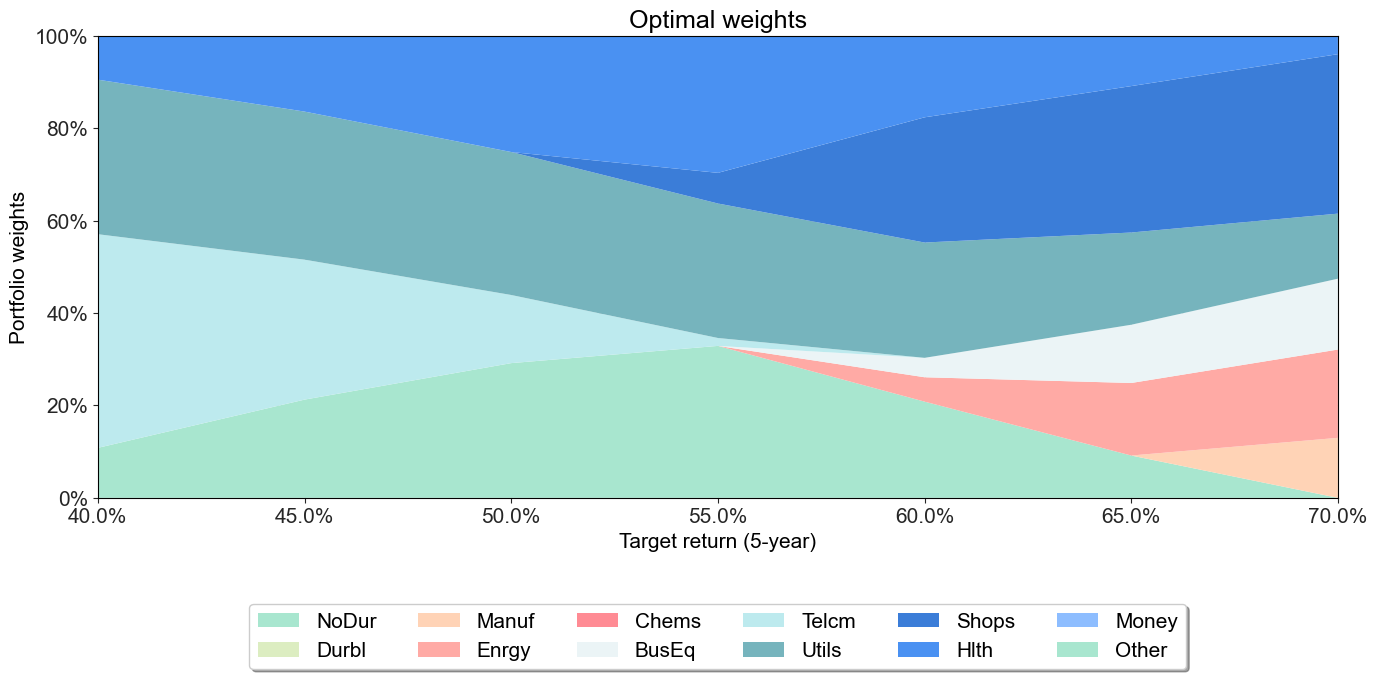

In [282]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [283]:
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, port_weights[i])[:, -1]
    value_at_risk = np.percentile(index_vals, 5)
    cond_value_at_risk = np.mean(index_vals[index_vals <= value_at_risk])
    print("CVaR(5%) for target = {}: ".format(targets[i]))
    print(cond_value_at_risk)
    print("\n")

CVaR(5%) for target = 1.4: 
0.7249626187404451


CVaR(5%) for target = 1.45: 
0.7868597285310783


CVaR(5%) for target = 1.5: 
0.8378129071455352


CVaR(5%) for target = 1.55: 
0.8761392905956974


CVaR(5%) for target = 1.6: 
0.8784978885989491


CVaR(5%) for target = 1.65: 
0.8439001571825551


CVaR(5%) for target = 1.7: 
0.7863300961309032




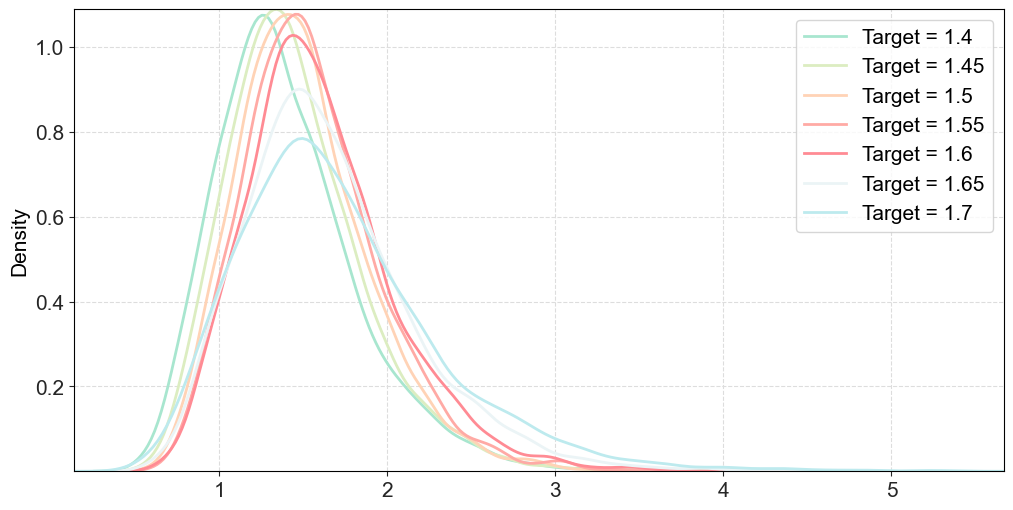

In [284]:
fig, ax = plt.subplots(figsize=(12, 6))    

for i in range(len(targets)):
    sns.kdeplot(calculate_constant_mix_index(asset_prices, port_weights[i])[:, -1],
                label="Target = {}".format(targets[i]))
    
ax.legend();

__Question 5__

We simply resample a number of paths from the simulated asset prices and perform the portfolio optimization again. Repeat this a large number of times. The average is the optimal allocations. 

In [286]:
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

num_resamples = 50
size_resample = 500
optimal_port_resampled_weights = np.zeros((len(targets), 12))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: target_return_constraint(x, target, asset_prices_sim)}


        x0 = np.r_[np.ones(12) / 12.0]
        res = optimize.minimize(objective_function, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x)


    optimal_port_resampled_weights += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights = np.array(optimal_port_resampled_weights)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


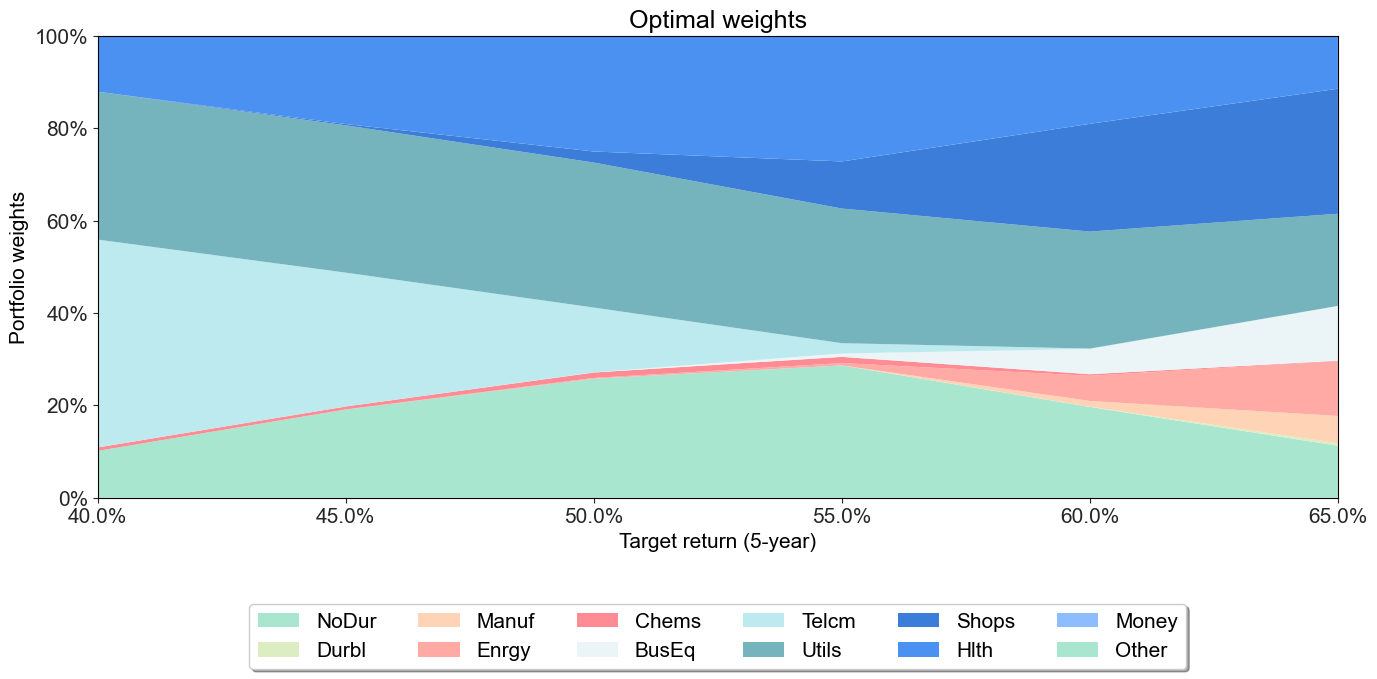

In [287]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, optimal_port_resampled_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [288]:
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, optimal_port_resampled_weights[i])[:, -1]
    value_at_risk = np.percentile(index_vals, 5)
    cond_value_at_risk = np.mean(index_vals[index_vals <= value_at_risk])
    print("CVaR(5%) for target = {}: ".format(targets[i]))
    print(cond_value_at_risk)
    print("\n")

CVaR(5%) for target = 1.4: 
0.7299158058329573


CVaR(5%) for target = 1.45: 
0.7916158614741959


CVaR(5%) for target = 1.5: 
0.8411875897285903


CVaR(5%) for target = 1.55: 
0.8769132045143592


CVaR(5%) for target = 1.6: 
0.8761385845696084


CVaR(5%) for target = 1.65: 
0.8425250145846932




__Question 6__

In [290]:
def objective_function_buy_and_hold(w, index, beta):

    buy_and_hold_index = (index @ w)[:, -1]

    return -calculate_conditional_value_at_risk(buy_and_hold_index, p = 1.0 - beta)

port_weights = list()
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

num_resamples = 50
size_resample = 500
optimal_port_resampled_weights_buy_and_hold = np.zeros((len(targets), 12))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: np.mean((asset_prices_sim @ x)[:, -1]) - target}


        x0 = np.r_[np.ones(12) / 12.0]
        res = optimize.minimize(objective_function_buy_and_hold, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x)


    optimal_port_resampled_weights_buy_and_hold += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights_buy_and_hold = np.array(optimal_port_resampled_weights_buy_and_hold)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


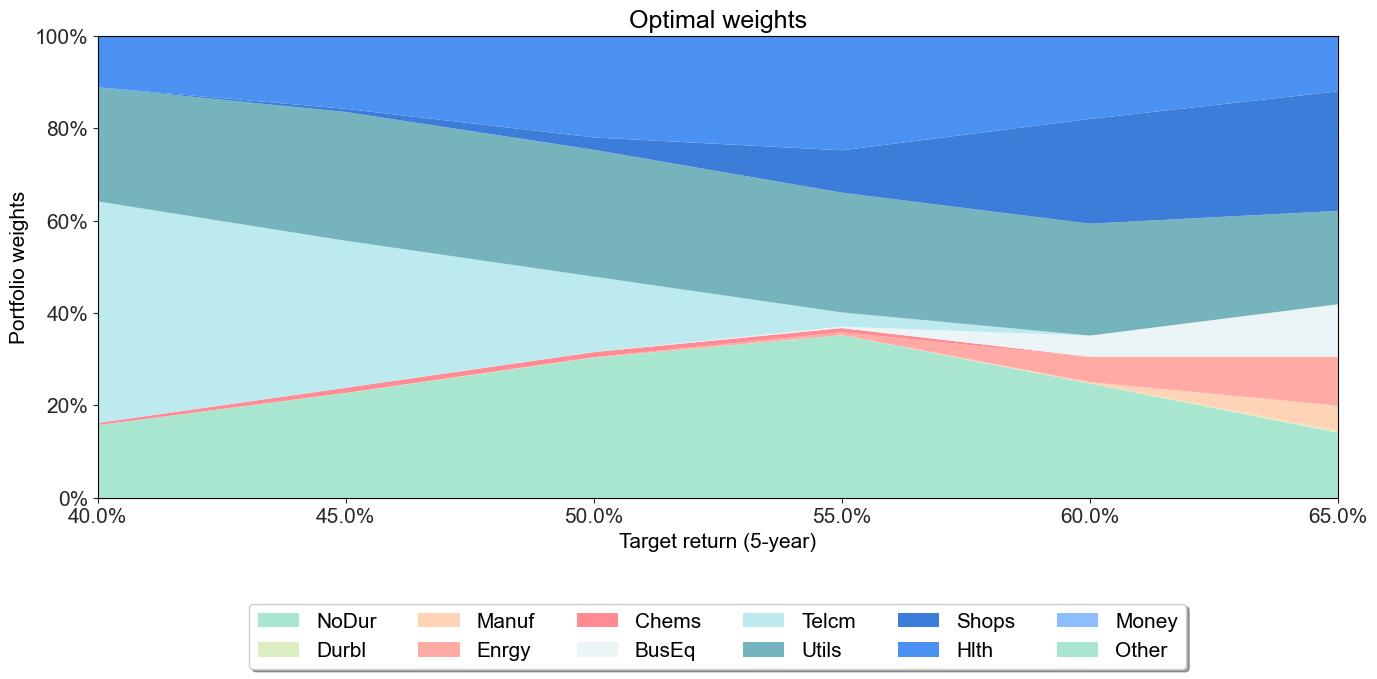

In [291]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, optimal_port_resampled_weights_buy_and_hold.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");